In [ ]:

import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# データセット読み込み
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            # labels.append([[0, t],[0, 1-t]]) # 2×2行列の形で格納するならこっち
            labels.append([1-t, t]) # 1×2行列の形
            sentences.append(line[1:].strip())
            
    return np.array(labels), sentences

train_labels, train_sentences = read_data('C:/Users/neoia//研究/data/mc_train_data_jp.txt')
dev_labels, dev_sentences = read_data('C:/Users/neoia//研究/data/mc_dev_data_jp.txt')
test_labels, test_sentences = read_data('C:/Users/neoia//研究/data/mc_test_data_jp.txt')

In [3]:
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ in ['NOUN','PRON']:
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))
    # 依存関係による型の割り当て（ペアと語順）
    
    for dep in dependencies:
        idx1 = tokens.index(dep[0])
        idx2 = tokens.index(dep[1])
        if idx1 < idx2:
            pregroup_types[token.head.text] = n.r @ pregroup_types[token.head.text]
        elif idx1 > idx2:
            pregroup_types[token.head.text] = pregroup_types[token.head.text] @ n.l
        else:
            pass

    return pregroup_types

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [6]:
train_diagrams = []
dev_diagrams = []
test_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    train_diagrams.append(create_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    dev_diagrams.append(create_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    test_diagrams.append(create_diagram(sentence))

In [7]:
def rotate_type(sentence: str, target_word: str, k: int = 1):
    
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)
    target_types = []
    rotated = []
    rotated_type = Ty()
    
    org_type = pregroup_types[target_word]
    target_types = list(org_type)
    
    def swap_with_prev(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i == 0:
            return d  # 先頭なら入れ替え不可
        items[i - 1], items[i] = items[i], items[i - 1]
        return dict(items)
    
    def swap_with_next(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i + 1 >= len(items):
            return d  # 最後尾なら無理
        items[i], items[i + 1] = items[i + 1], items[i]
        return dict(items)
    
    k = k % len(target_types)  # リスト長で割った余りだけ回す
    rotated = target_types[k:] + target_types[:k]
    
    rotated_types = target_types[:k]
    slided_types = target_types[k:]
    if k <= target_types.index(s):
        for i in range(len(rotated_types)):
            # 右随伴なら
            if  rotated_types[i] == n.r:
                pregroup_types = swap_with_prev(pregroup_types,target_word)
                rotated_types[i] = n.l 
                
            else:
                pass

    else:
        for i in range(len(slided_types)):       
            if  slided_types[i] == n.r:
                pregroup_types = swap_with_next(pregroup_types,target_word)
                slided_types[i] = n.l 
            else:
                pass
    rotated = slided_types + rotated_types
    
    for i in rotated:
        rotated_type @= i
    rotated_type
    
    pregroup_types[target_word] = rotated_type
    
    return pregroup_types

In [8]:
# diagram作成
def create_rotated_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = rotate_type(doc, target_word)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [11]:
train_rot_types = []
dev_rot_types = []
test_rot_types = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    train_rot_types.append(rotate_type(sentence, target_word))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    dev_rot_types.append(rotate_type(sentence, target_word))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    test_rot_types.append(rotate_type(sentence, target_word))
# check diagrams
for d in range(len(train_sentences)):
    print(train_rot_types[d])

{'男': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, 'ソース': Ty(n)}
{'男': Ty(n), '焼き': Ty(n).r @ Ty(s) @ Ty(n).l, '夕食': Ty(n)}
{'女性': Ty(n), '作っ': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'男': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'女性': Ty(n), 'デバッグ': Ty(n).r @ Ty(s) @ Ty(n).l, 'プログラム': Ty(n)}
{'女性': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'人': Ty(n), '実行': Ty(n).r @ Ty(s) @ Ty(n).l, 'プログラム': Ty(n)}
{'人': Ty(n), '実行': Ty(n).r @ Ty(s) @ Ty(n).l, 'アプリケーション': Ty(n)}
{'女性': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, 'ソース': Ty(n)}
{'女性': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, '夕食': Ty(n)}
{'人': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'人': Ty(n), '焼き': Ty(n).r @ Ty(s) @ Ty(n).l, '夕食': Ty(n)}
{'女性': Ty(n), '焼き': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'女性': Ty(n), '実行': Ty(n).r @ Ty(s) @ Ty(n).l, 'アプリケーション': Ty(n)}
{'男': Ty(n), '焼き': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'人': Ty(n), '準備': Ty(n).r @ Ty(s) @ Ty(n).l, '食事': Ty(n)}
{'女性': Ty(n), '実行': Ty(n).r

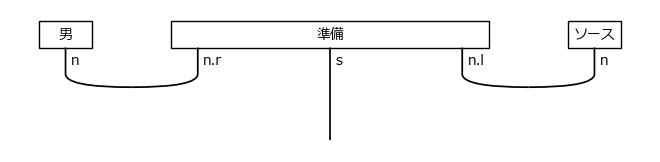

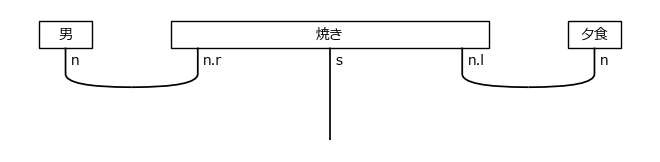

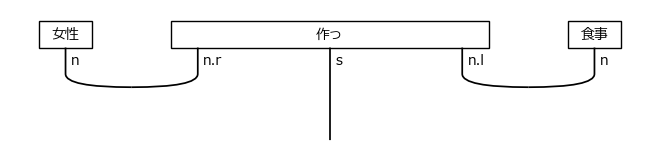

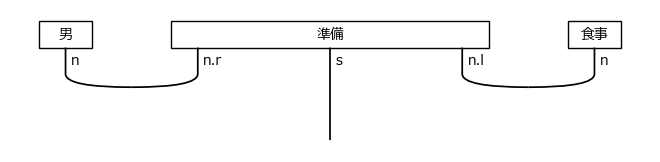

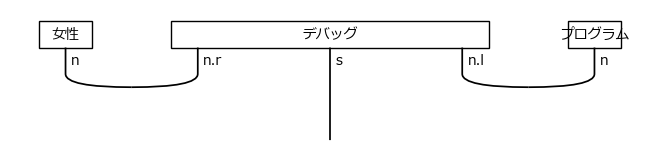

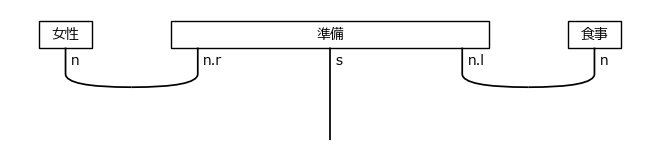

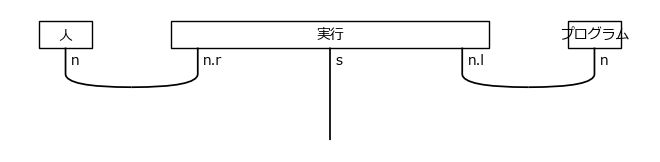

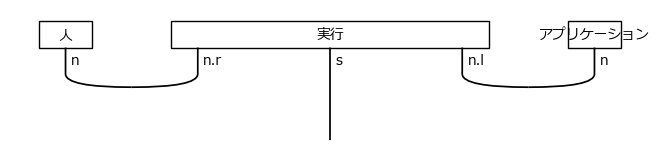

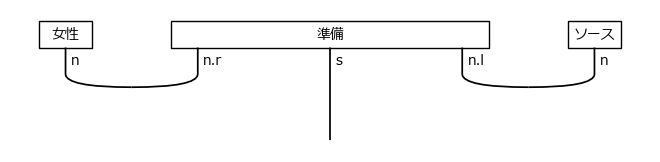

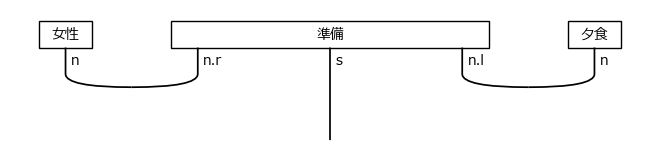

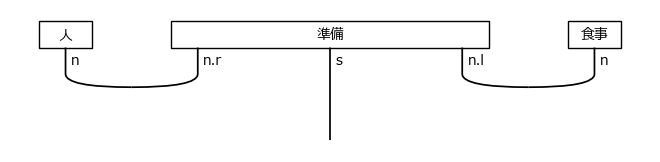

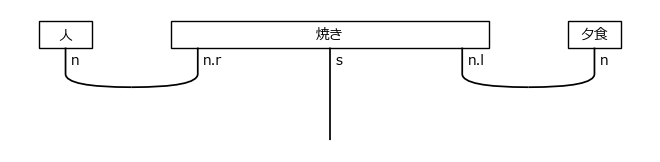

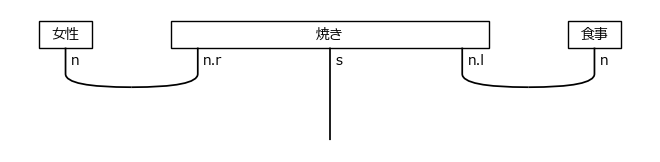

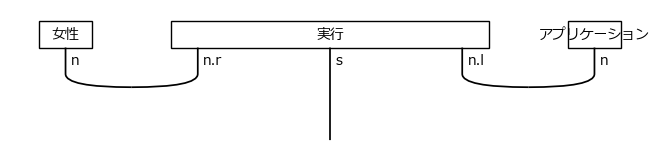

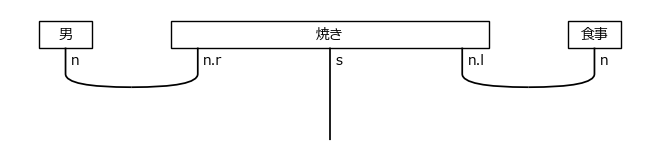

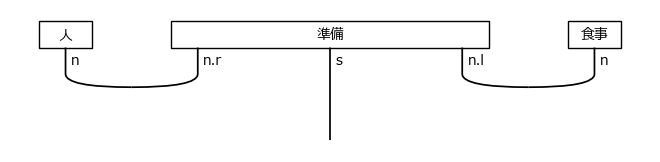

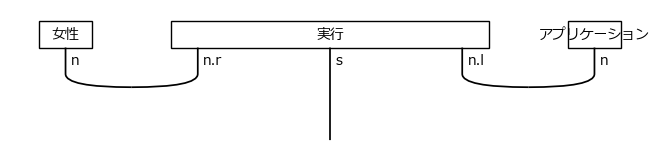

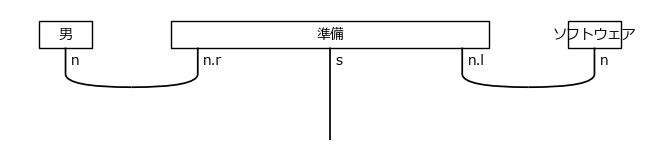

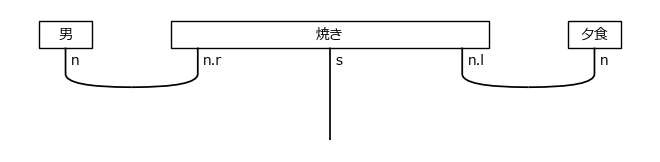

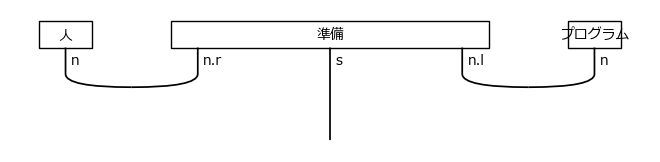

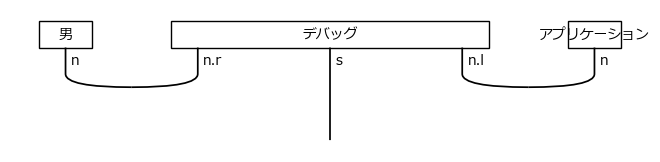

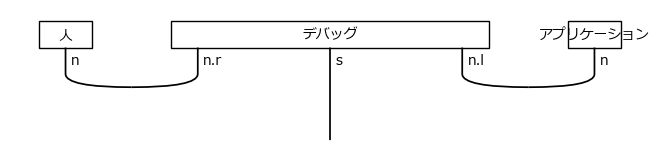

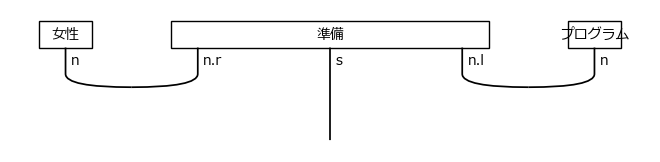

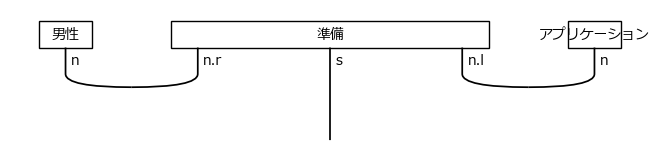

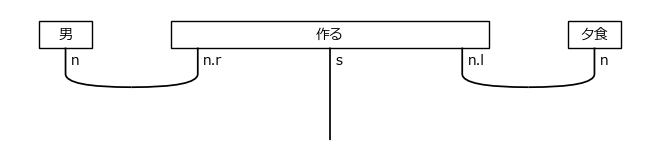

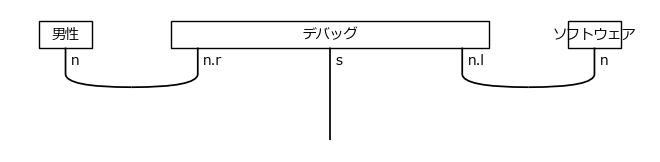

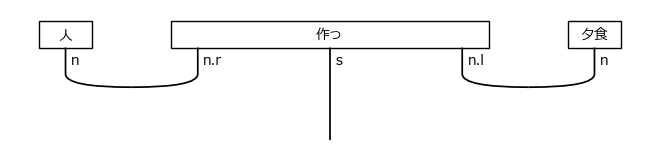

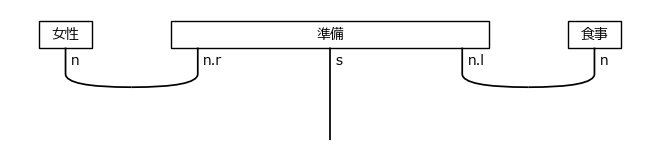

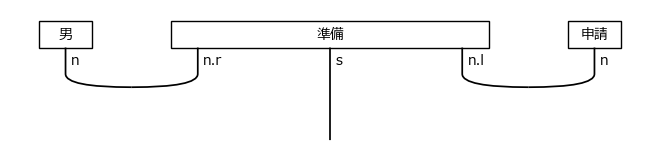

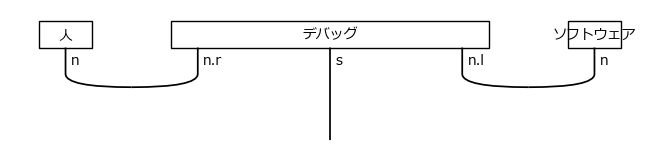

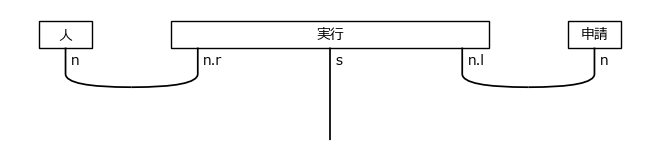

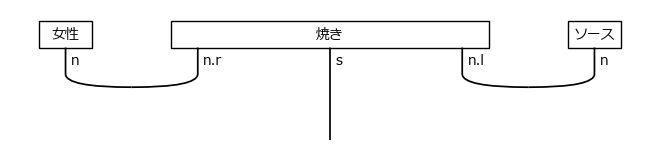

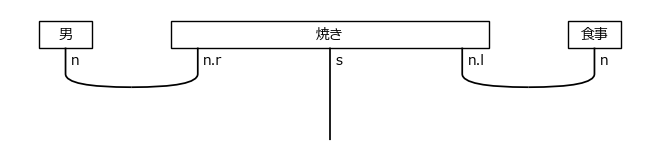

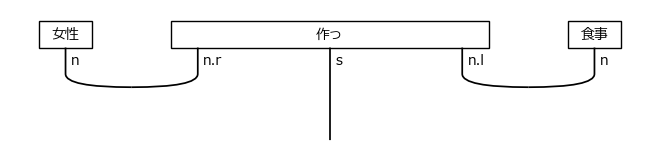

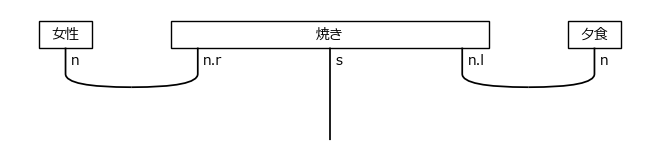

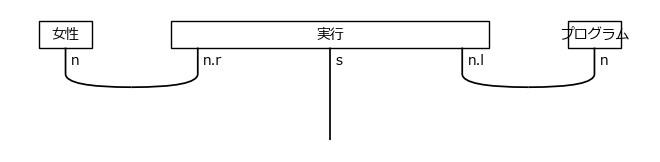

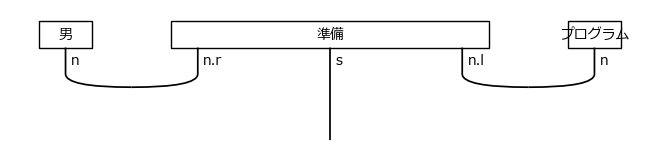

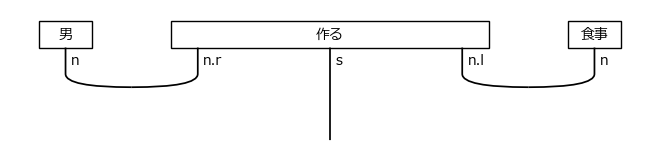

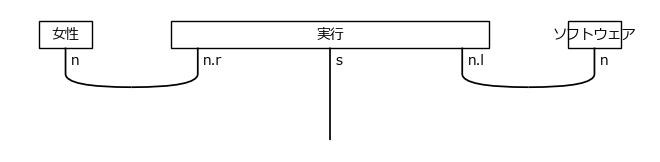

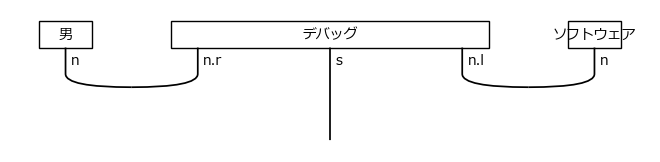

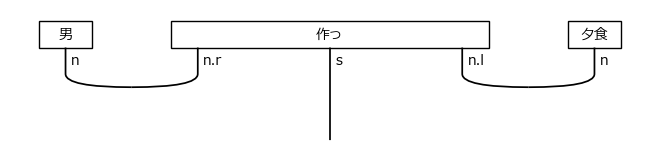

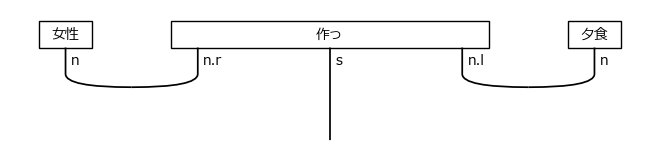

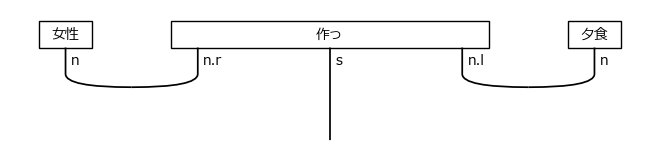

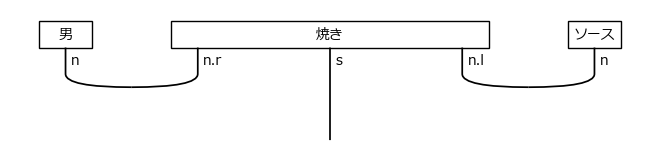

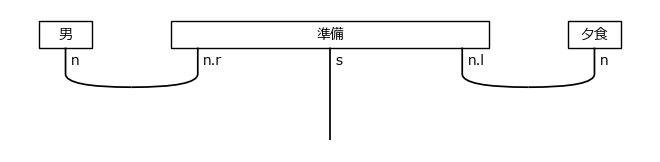

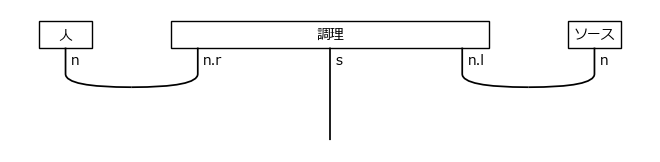

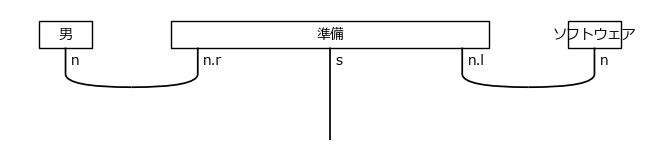

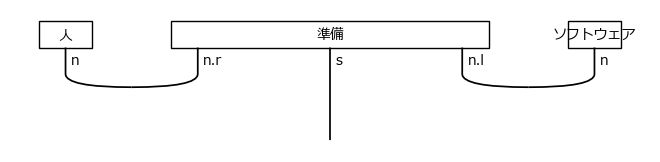

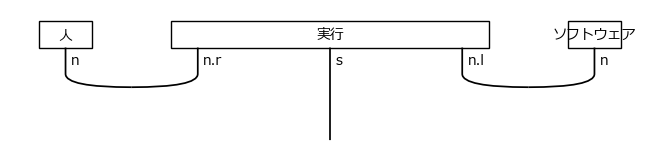

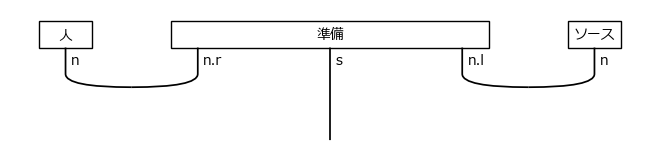

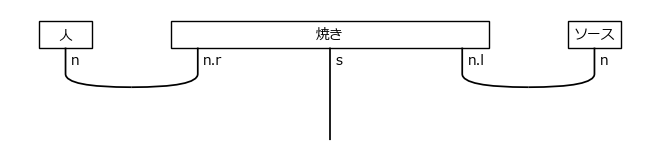

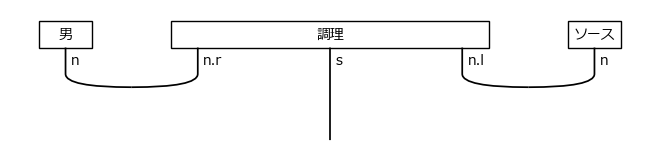

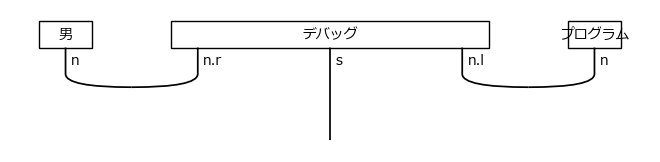

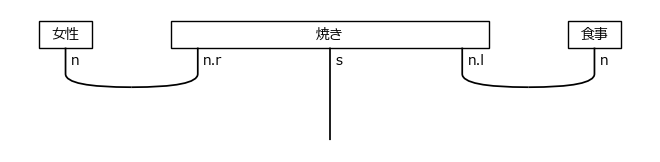

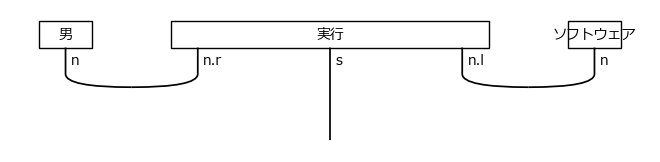

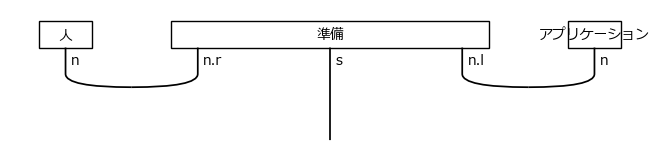

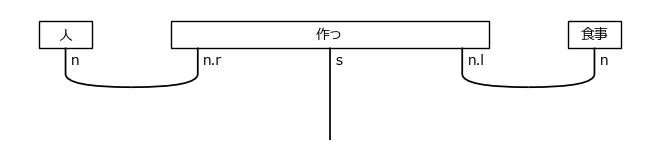

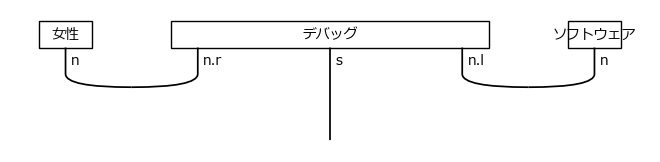

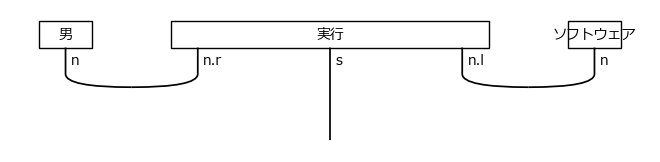

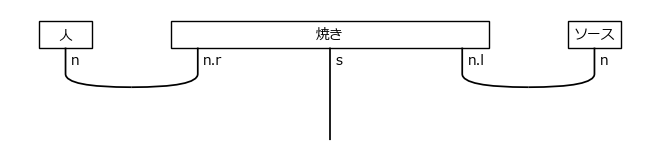

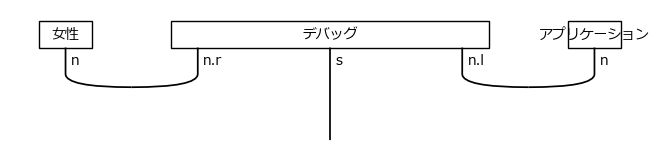

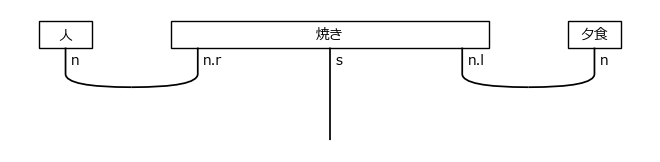

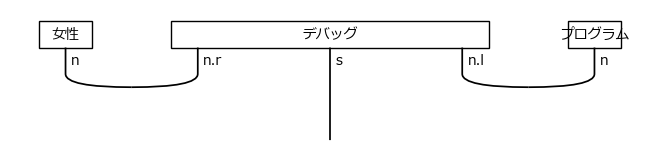

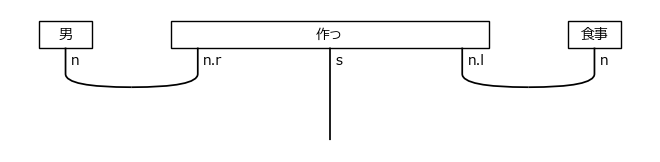

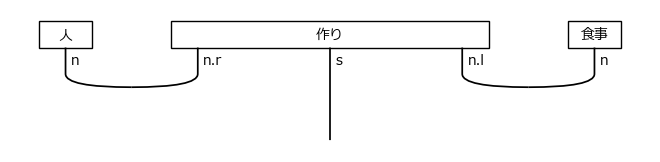

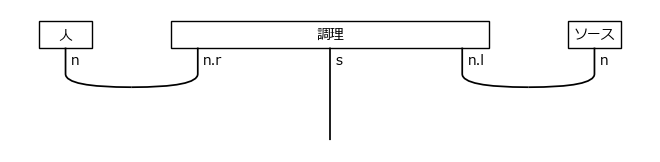

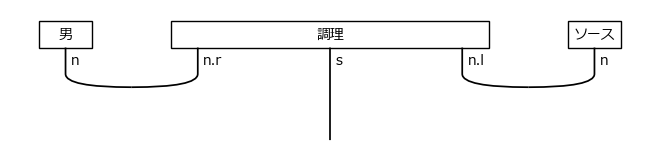

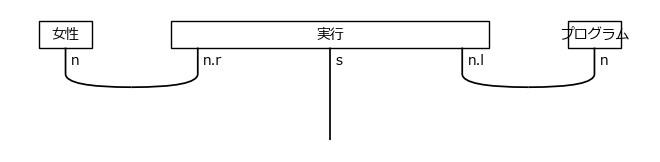

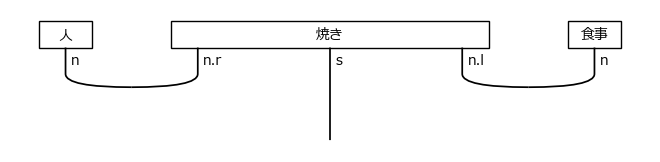

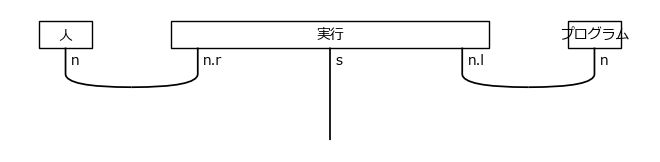

In [12]:
train_rot_diagrams = []
dev_rot_diagrams = []
test_rot_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    train_rot_diagrams.append(create_rotated_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    dev_rot_diagrams.append(create_rotated_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    test_rot_diagrams.append(create_rotated_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_rot_diagrams[d])

In [13]:
# diagram作成
def create_rotated_type_in_order_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_type_rotated_in_order(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [17]:
def assign_type_rotated_in_order(sentence):
    doc = nlp(sentence)
    pregroup_types = rotate_type(doc, target_word)

    rotated_words = list(pregroup_types.keys())
    
    for i in range(len(rotated_words)):
        word_in_rotated_words = rotated_words[i]
        if i == 0:
            pregroup_types[word_in_rotated_words] = n
        elif i < len(rotated_words) -1:
            pregroup_types[word_in_rotated_words] = n.r @ n
        elif i == len(rotated_words) -1:
            pregroup_types[word_in_rotated_words] = n.r @ s
        
    return pregroup_types

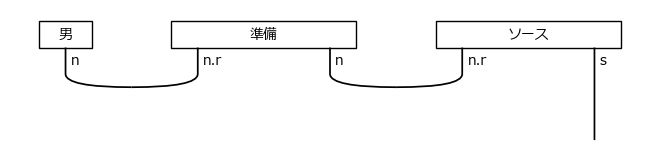

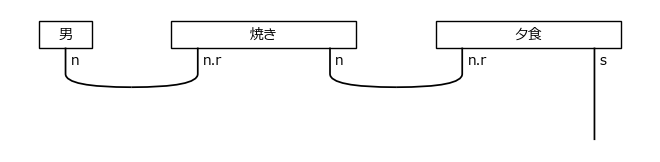

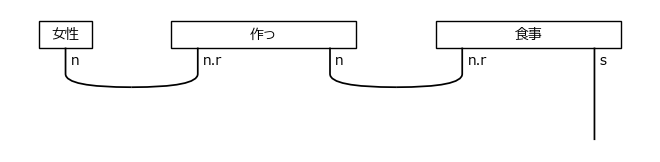

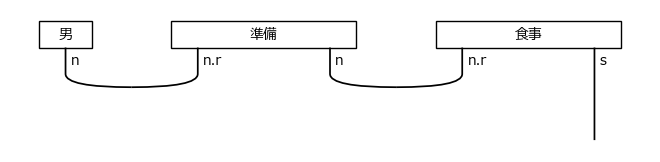

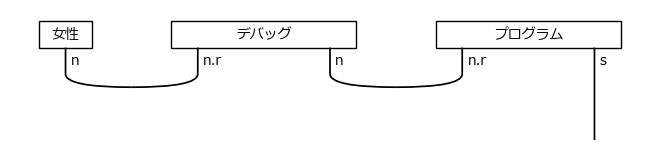

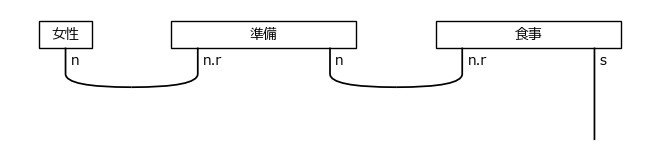

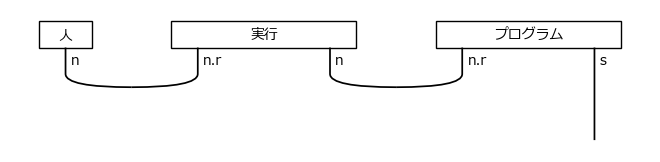

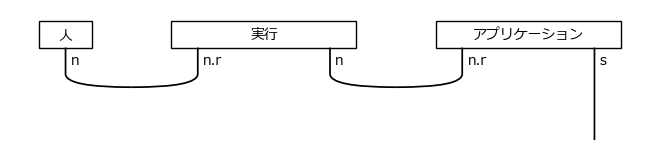

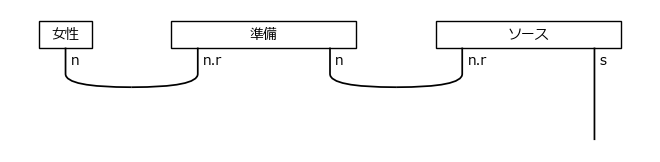

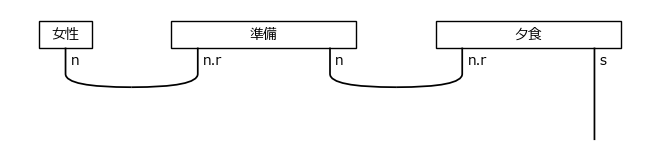

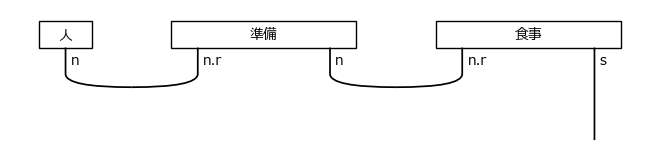

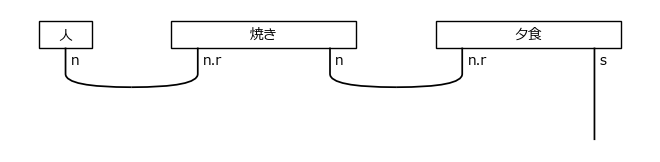

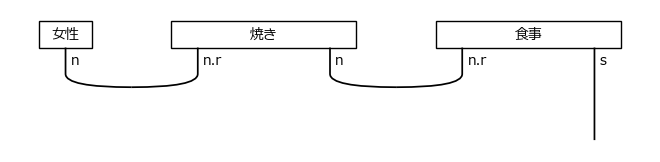

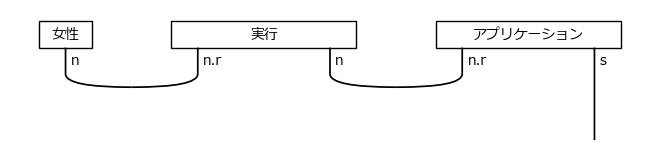

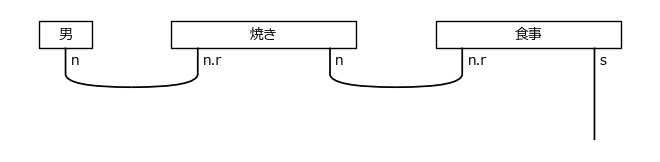

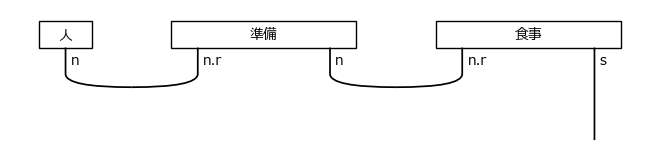

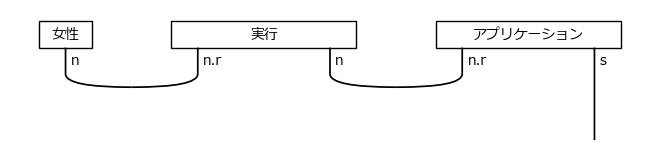

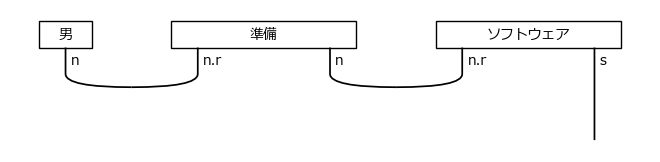

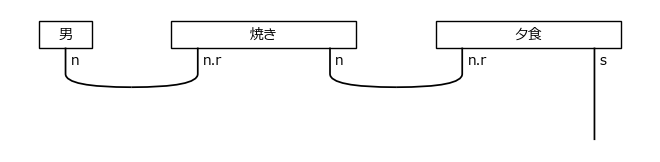

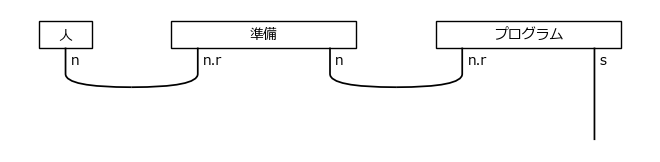

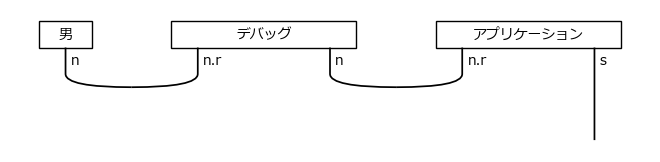

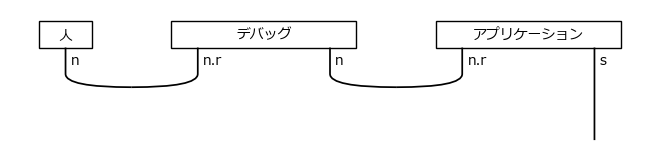

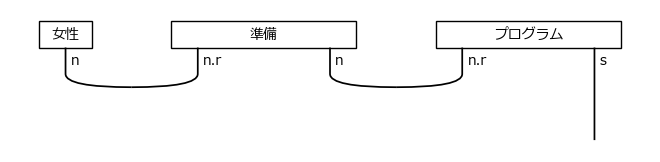

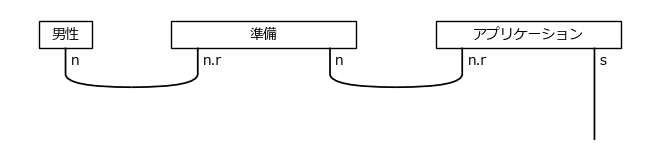

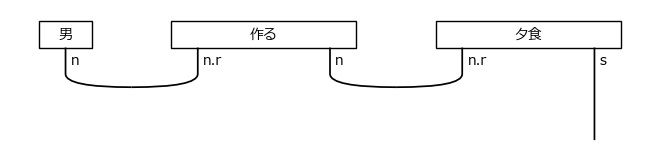

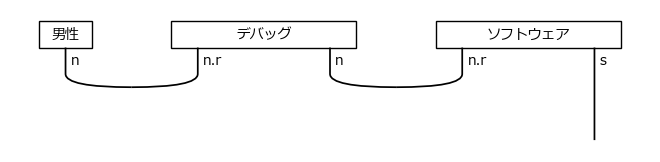

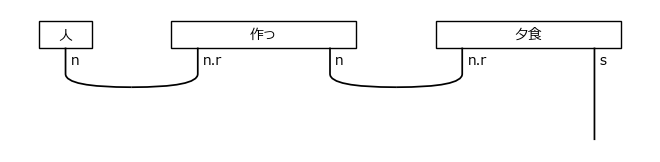

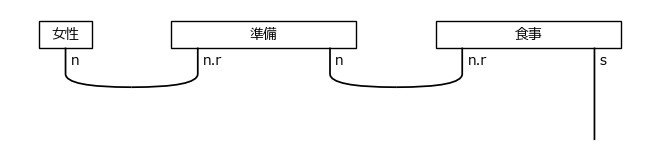

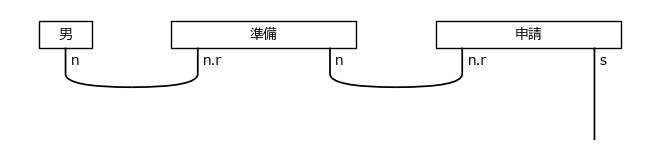

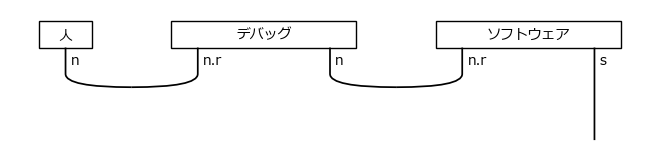

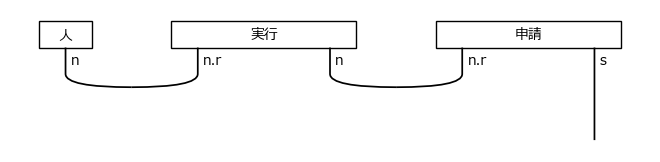

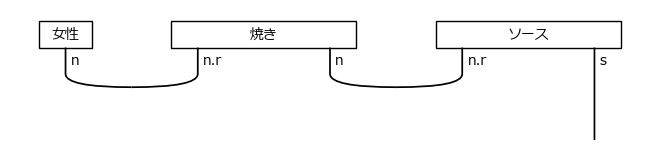

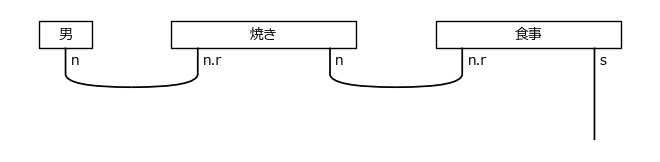

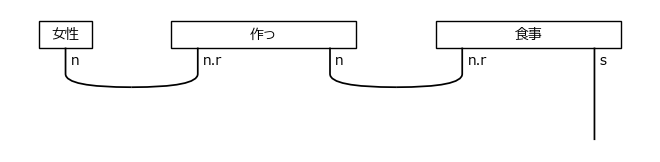

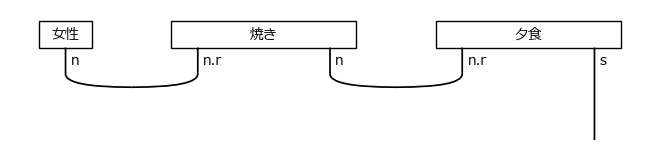

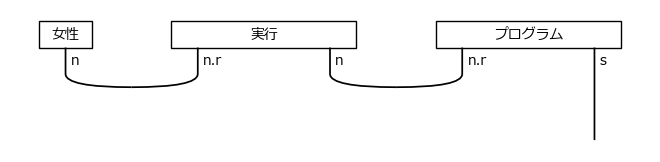

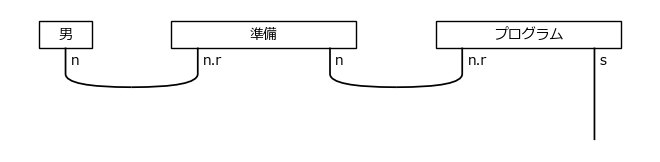

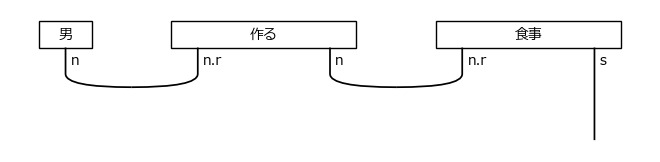

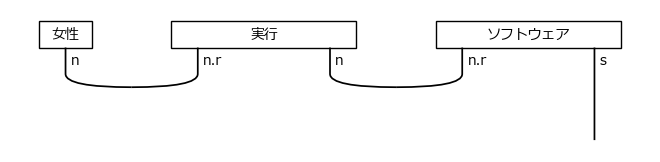

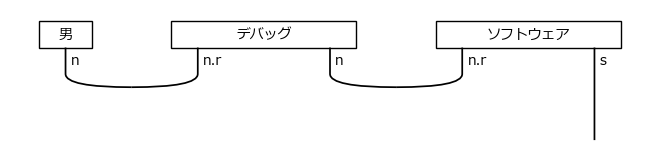

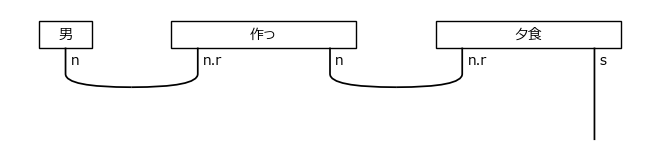

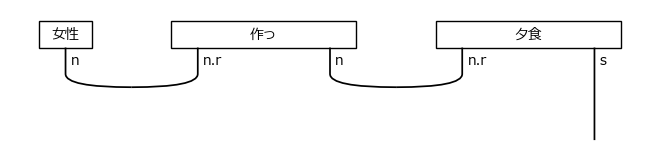

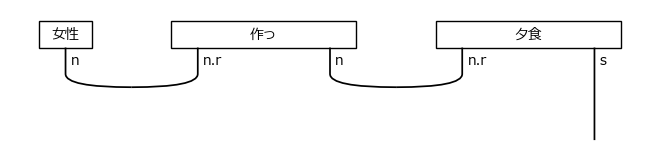

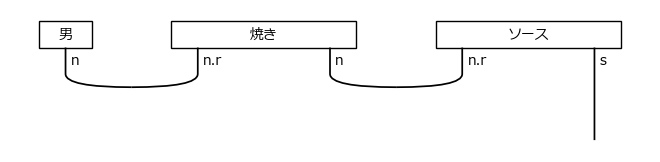

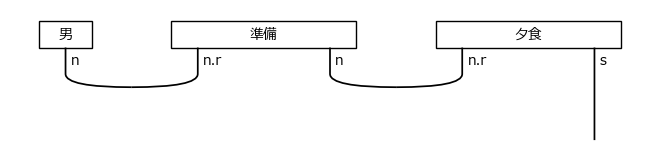

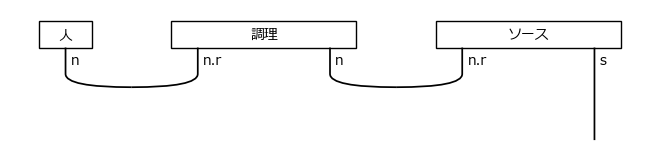

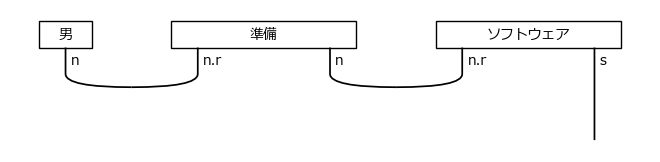

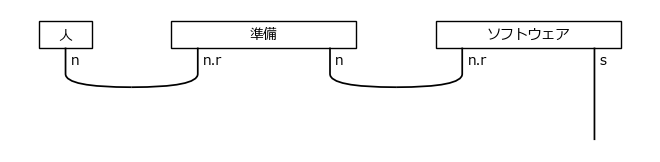

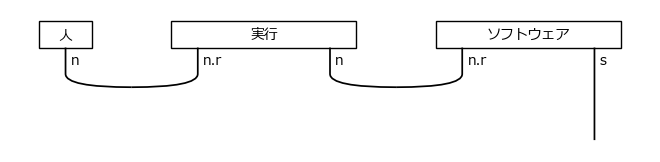

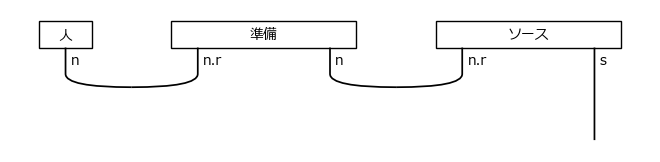

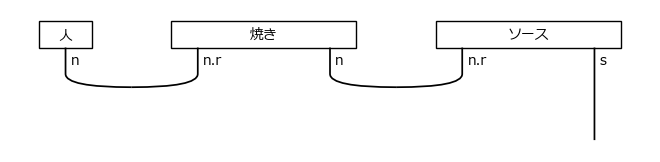

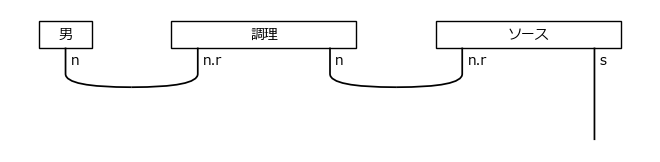

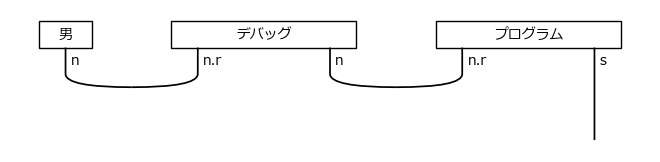

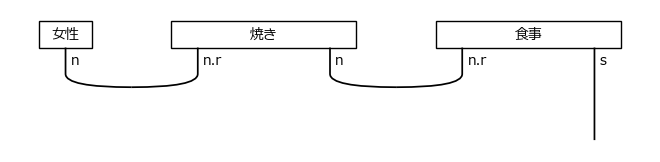

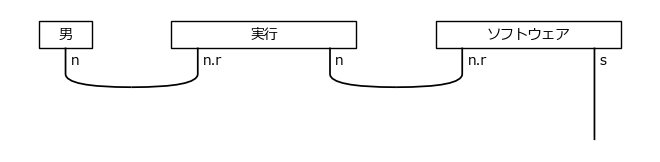

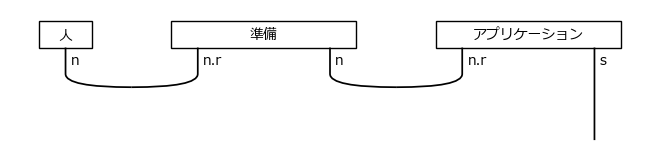

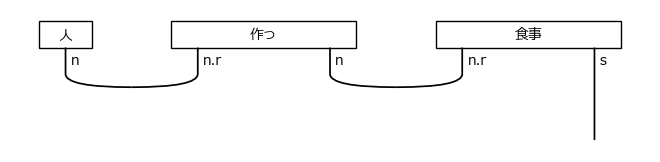

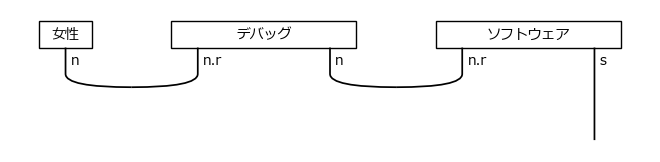

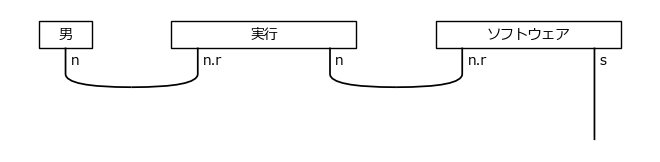

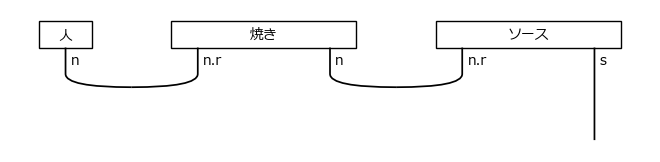

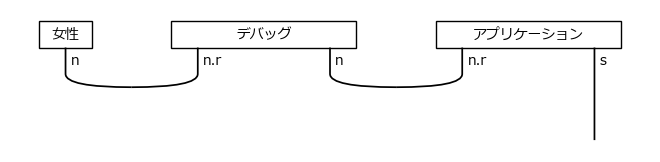

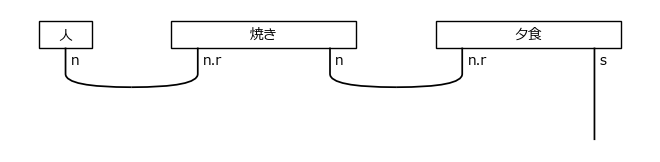

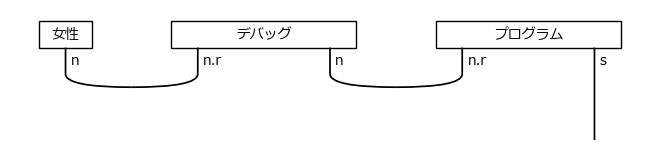

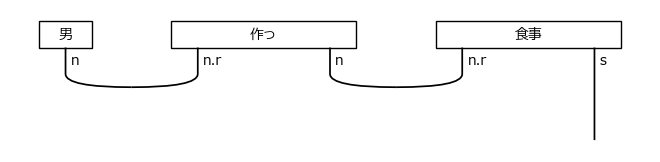

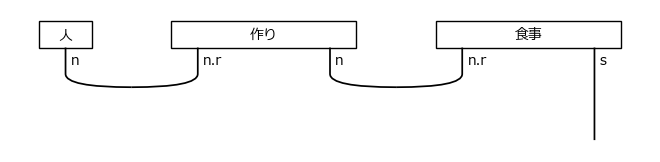

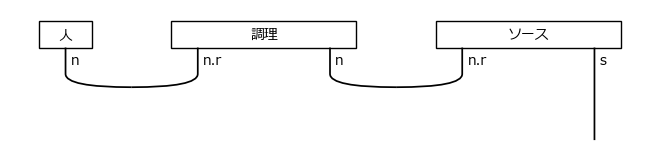

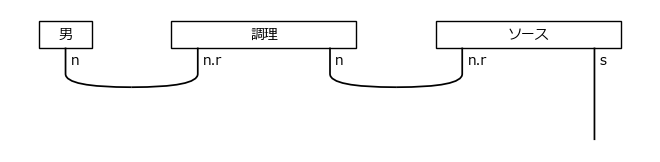

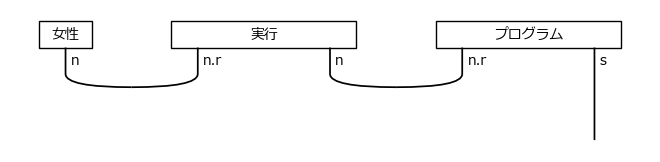

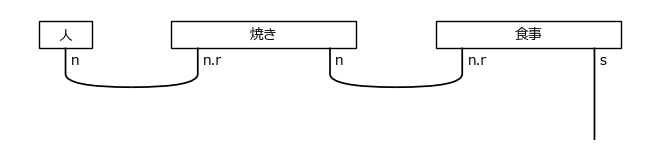

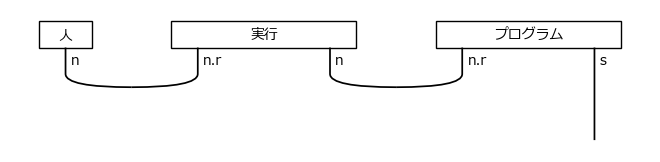

In [18]:
train_rot_in_order_diagrams =[]
dev_rot_in_order_diagrams = []
test_rot_in_order_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    train_rot_in_order_diagrams.append(create_rotated_type_in_order_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    dev_rot_in_order_diagrams.append(create_rotated_type_in_order_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    test_rot_in_order_diagrams.append(create_rotated_type_in_order_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_rot_in_order_diagrams[d])

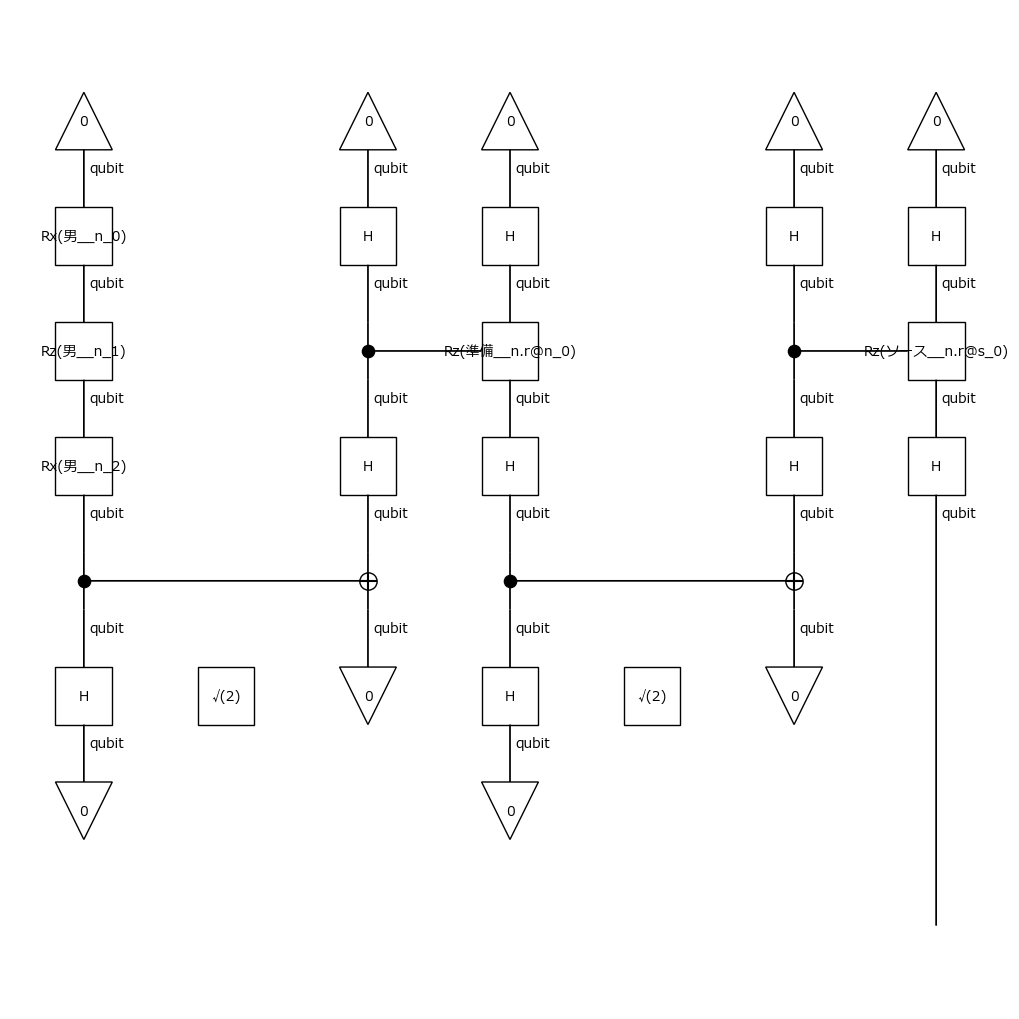

In [19]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_rot_in_order_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_rot_in_order_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_rot_in_order_diagrams]

train_circuits[0].draw(figsize=(10, 10))

In [20]:
# 量子回路シミュレーションをする計算モデルを構築
all_circuits = train_circuits + dev_circuits + test_circuits # モデル初期化時に全量子回路を提供するための準備
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数と予測精度の定義
bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
# roundで四捨五入して0or1に変換  # 正解数を総数で割る

In [21]:
# ハイパーパラメータ
BATCH_SIZE = 30
# LEARNING_RATE = 3e-2
EPOCHS = 400
SEED = 0

# trainerの定義
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.1, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=SEED
)

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [22]:
trainer.fit(train_dataset, val_dataset, log_interval=100)

Epoch 100:  train/loss: 0.0464   valid/loss: 0.0550   train/time: 1m2s   valid/time: 5.21s   train/acc: 0.9571   valid/acc: 1.0000
Epoch 200:  train/loss: 0.1477   valid/loss: 0.0322   train/time: 14.24s   valid/time: 3.92s   train/acc: 0.9714   valid/acc: 1.0000
Epoch 300:  train/loss: 0.0412   valid/loss: 0.0255   train/time: 13.72s   valid/time: 3.80s   train/acc: 0.9571   valid/acc: 1.0000
Epoch 400:  train/loss: 0.2228   valid/loss: 0.0205   train/time: 13.47s   valid/time: 3.80s   train/acc: 0.9571   valid/acc: 1.0000

Training completed!
train/time: 1m43s   train/time_per_epoch: 0.26s   train/time_per_step: 0.09s   valid/time: 16.72s   valid/time_per_eval: 0.04s


Train accuracy: 0.95714283
Test accuracy: 1.0


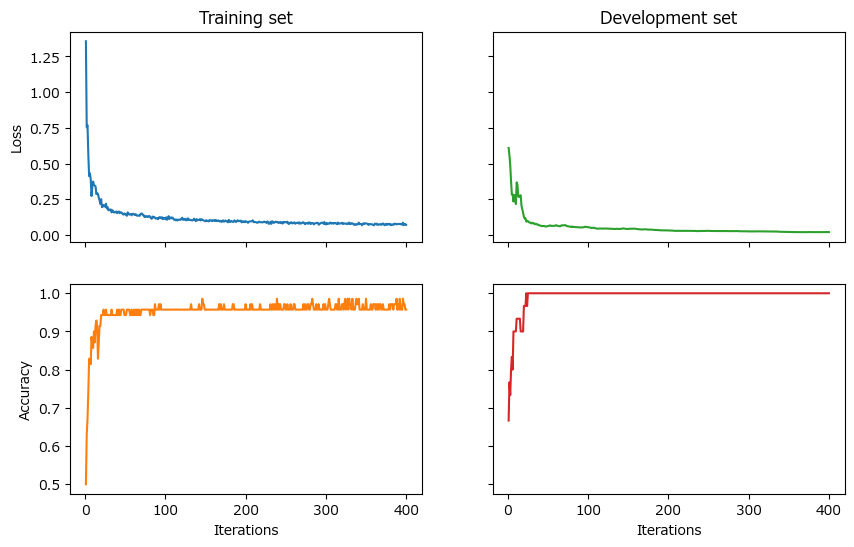

In [23]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

train_acc = acc(model(train_circuits), np.array(train_labels))
test_acc = acc(model(test_circuits), np.array(test_labels))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)